## Marcel For The NFL

The Marcel the Monkey projection system is a system developed by Tom Tango for baseball projections (It has also been translated to sports such as hockey:https://ownthepuck.wordpress.com/2015/09/05/using-marcels-to-forecast-player-performance-in-hockey/ and basketball: https://www.basketball-reference.com/about/projections.html). The system is incredibly simple yet incredibly powerful, usually performing on par with much more complex projections systems for baseball (http://www.insidethebook.com/ee/index.php/site/comments/forecast_evaluations/). The idea is simple: weight each of the past three seasons of player's career, giving more weight to the most recent season (I'll discuss how these weights are established later), then get the league average for those seasons with the same amount of 'playing time', and add those numbers together, which regresses the player's performance towards the mean. After that, use an aging curve (made by the Delta Method: https://mglbaseball.com/2016/12/21/a-new-method-of-constructing-more-accurate-aging-curves/) to determine the how the player should play relative to last year as a result of being one year older.

In baseball, the 'playing time' component is plate appearances (for hitters), and so the obvious parallels for football would by rushing attempts (for running backs), passing attempts (for quarterbacks), and targets (for receivers and tight ends). We can project a variety of statistics for each player using this methodology, but for this project, I'll be looking at two: DYAR (Defensive Adjusted Yards Above Replacement) and Yds (Effective Yards), both stats developed by Football Outsiders that can be read about here: https://www.footballoutsiders.com/info/glossary. Since not all players have three years of experience, I'll also be using modified weights for players with only two seasons.

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)
import warnings; warnings.simplefilter('ignore')
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model

In [6]:
# Get Data from /Data
qb_bdays = pd.read_csv("Data/qb_bdays.csv", header = None, names = ['Index','Birthdate', 'Name'], index_col = 'Index')
rb_bdays = pd.read_csv("Data/rb_bdays.csv", header = None, names = ['Index','Birthdate', 'Name'], index_col = 'Index')
wr_bdays = pd.read_csv("Data/wr_bdays.csv", header = None, names = ['Index','Birthdate', 'Name'], index_col = 'Index')
te_bdays = pd.read_csv("Data/te_bdays.csv", header = None, names = ['Index','Birthdate', 'Name'], index_col = 'Index')

qb_stats = pd.read_csv("Data/qbdata.csv", thousands=',')
rb_stats_rush = pd.read_csv("Data/rbdata_rush.csv", thousands=',')
rb_stats_rec = pd.read_csv("Data/rbdata_rec.csv", thousands=',')
wr_stats = pd.read_csv("Data/wrdata.csv", thousands=',')
te_stats = pd.read_csv("Data/tedata.csv", thousands=',')

#Drop Players with unknown birthdays, convert birthdays to datetimes
qb_bdays.dropna(inplace = True)
qb_bdays['Birthdate'] = pd.to_datetime(qb_bdays['Birthdate'], format  = '%m/%d/%Y', errors = 'coerce')

rb_bdays.dropna(inplace = True)
rb_bdays['Birthdate'] = pd.to_datetime(rb_bdays['Birthdate'], format  = '%m/%d/%Y', errors = 'coerce')

wr_bdays.dropna(inplace = True)
wr_bdays['Birthdate'] = pd.to_datetime(wr_bdays['Birthdate'], format  = '%m/%d/%Y', errors = 'coerce')

te_bdays.dropna(inplace = True)
te_bdays['Birthdate'] = pd.to_datetime(te_bdays['Birthdate'], format  = '%m/%d/%Y', errors = 'coerce')

#left join stats with player birthdate
qb_bdays.rename(columns = {'Name':'Player'}, inplace = True)
qb_stats = qb_stats.merge(qb_bdays, on = 'Player', how = 'left')

rb_bdays.rename(columns = {'Name':'Player'}, inplace = True)
rb_stats_rush = rb_stats_rush.merge(rb_bdays, on = 'Player', how = 'left')
rb_stats_rec = rb_stats_rec.merge(rb_bdays, on = 'Player', how = 'left')

wr_bdays.rename(columns = {'Name':'Player'}, inplace = True)
wr_stats = wr_stats.merge(wr_bdays, on = 'Player', how = 'left')

te_bdays.rename(columns = {'Name':'Player'}, inplace = True)
te_stats = te_stats.merge(te_bdays, on = 'Player', how = 'left')

#Convert Year in player stats to datetime
qb_stats['Year'] = pd.to_datetime(qb_stats['Year'], format = '%Y')
rb_stats_rush['Year'] = pd.to_datetime(rb_stats_rush['Year'], format = '%Y')
rb_stats_rec['Year'] = pd.to_datetime(rb_stats_rec['Year'], format = '%Y')
wr_stats['Year'] = pd.to_datetime(wr_stats['Year'], format = '%Y')
te_stats['Year'] = pd.to_datetime(te_stats['Year'], format = '%Y')

# get player age at start of each season
qb_stats = qb_stats[~(qb_stats['Birthdate'].isnull())]
qb_stats['Age'] = (qb_stats['Year'] - qb_stats['Birthdate'])
qb_stats['Age'] = qb_stats['Age'].apply(lambda x: float(x.days)/365)

rb_stats_rush = rb_stats_rush[~(rb_stats_rush['Birthdate'].isnull())]
rb_stats_rush['Age'] = (rb_stats_rush['Year'] - rb_stats_rush['Birthdate'])
rb_stats_rush['Age'] = rb_stats_rush['Age'].apply(lambda x: float(x.days)/365)

rb_stats_rec = rb_stats_rec[~(rb_stats_rec['Birthdate'].isnull())]
rb_stats_rec['Age'] = (rb_stats_rec['Year'] - rb_stats_rec['Birthdate'])
rb_stats_rec['Age'] = rb_stats_rec['Age'].apply(lambda x: float(x.days)/365)

wr_stats = wr_stats[~(wr_stats['Birthdate'].isnull())]
wr_stats['Age'] =(wr_stats['Year'] - wr_stats['Birthdate'])
wr_stats['Age'] = wr_stats['Age'].apply(lambda x: float(x.days)/365)

te_stats = te_stats[~(te_stats['Birthdate'].isnull())]
te_stats['Age'] =(te_stats['Year'] - te_stats['Birthdate'])
te_stats['Age'] = te_stats['Age'].apply(lambda x: float(x.days)/365)

#Get Differences Between Year -> Year t now includes DYAR for year t+1 for training
#Last Year is NA for DYAR_-1
qb_stats['DYAR_t+1'] = qb_stats.sort_values('Age').groupby(['Player','Birthdate'])['DYAR'].shift(-1)
rb_stats_rush['DYAR_t+1'] = rb_stats_rush.sort_values('Age').groupby(['Player','Birthdate'])['DYAR'].shift(-1)
rb_stats_rec['DYAR_t+1'] = rb_stats_rec.sort_values('Age').groupby(['Player','Birthdate'])['DYAR'].shift(-1)
wr_stats['DYAR_t+1'] = wr_stats.sort_values('Age').groupby(['Player','Birthdate'])['DYAR'].shift(-1)
te_stats['DYAR_t+1'] = te_stats.sort_values('Age').groupby(['Player','Birthdate'])['DYAR'].shift(-1)

# Get passes, rushes, passes to for year t+1
qb_stats['Passes_t+1'] = qb_stats.sort_values('Age').groupby(['Player','Birthdate'])['Passes'].shift(-1)
rb_stats_rush['Rushes_t+1'] = rb_stats_rush.sort_values('Age').groupby(['Player','Birthdate'])['Rushes'].shift(-1)
rb_stats_rec['Targets_t+1'] = rb_stats_rec.sort_values('Age').groupby(['Player','Birthdate'])['Targets'].shift(-1)
wr_stats['Targets_t+1'] = wr_stats.sort_values('Age').groupby(['Player','Birthdate'])['Targets'].shift(-1)
te_stats['Targets_t+1'] = te_stats.sort_values('Age').groupby(['Player','Birthdate'])['Targets'].shift(-1)

#take % sign from Suc_rate, Catch_rate
rb_stats_rush['Suc_rate'] = rb_stats_rush['Suc_rate'].str.extract(r"(\d+)%")
rb_stats_rush['Suc_rate'] = rb_stats_rush['Suc_rate'].fillna(0)

rb_stats_rec['Catch_rate'] = rb_stats_rec['Catch_rate'].str.extract(r"(\d+)%")
rb_stats_rec['Catch_rate'] = rb_stats_rec['Catch_rate'].fillna(0)

wr_stats['Catch_rate'] = wr_stats['Catch_rate'].str.extract(r"(\d+)%")
wr_stats['Catch_rate'] = wr_stats['Catch_rate'].fillna(0)

te_stats['Catch_rate'] = te_stats['Catch_rate'].str.extract(r"(\d+)%")
te_stats['Catch_rate'] = te_stats['Catch_rate'].fillna(0)

In [7]:
## Get league average DYAR/Rush, DYAR/Pass, DYAR/Target
def get_avg_stat(position,stat):
    touches = ''
    if position == "rb_rush":
        df = rb_stats_rush
        touches = "Rushes"
    elif position == "rb_rec":
        df = rb_stats_rec
        touches = "Targets"    
    elif position == "qb":
        df = qb_stats
        touches = "Passes"
    elif position == "wr":
        df = wr_stats
        touches = "Targets"
    elif position == "te":
        df = te_stats
        touches = "Targets"
        
    league_avg = df.groupby('Year').sum()[stat] / df.groupby('Year').sum()[touches]
    avg_stat = []
    for index, row in df.iterrows():
        avg_stat.append(row[touches] * league_avg[row['Year']])
    return avg_stat

def get_past_stat(stat,df):
    # Get STAT from 1, 2 and 3 years ago for regression model
    df['{}_t-1'.format(stat)] = df.sort_values('Age').groupby(['Player','Birthdate'])[stat].shift(1)
    df['{}_t-2'.format(stat)] = df.sort_values('Age').groupby(['Player','Birthdate'])[stat].shift(2)
    df['{}_t-3'.format(stat)] = df.sort_values('Age').groupby(['Player','Birthdate'])[stat].shift(3)


In [8]:
rb_stats_rush['ADYAR'] = get_avg_stat('rb_rush','DYAR')
rb_stats_rec['ADYAR'] = get_avg_stat('rb_rec','DYAR')
qb_stats['ADYAR'] = get_avg_stat('qb','DYAR')
wr_stats['ADYAR'] = get_avg_stat('wr','DYAR')
te_stats['ADYAR'] = get_avg_stat('te','DYAR')

rb_stats_rush['AYds'] = get_avg_stat('rb_rush','Yds')
rb_stats_rec['AYds'] = get_avg_stat('rb_rec','Yds')
qb_stats['AYds'] = get_avg_stat('qb','Yds')
wr_stats['AYds'] = get_avg_stat('wr','Yds')
te_stats['AYds'] = get_avg_stat('te','Yds')

get_past_stat('Rushes',rb_stats_rush)
get_past_stat('Targets',rb_stats_rec)
get_past_stat('Passes',qb_stats)
get_past_stat('Targets',wr_stats)
get_past_stat('Targets',te_stats)

get_past_stat('DYAR',rb_stats_rush)
get_past_stat('DYAR',rb_stats_rec)
get_past_stat('DYAR',qb_stats)
get_past_stat('DYAR',wr_stats)
get_past_stat('DYAR',te_stats)

get_past_stat('ADYAR',rb_stats_rush)
get_past_stat('ADYAR',rb_stats_rec)
get_past_stat('ADYAR',qb_stats)
get_past_stat('ADYAR',wr_stats)
get_past_stat('ADYAR',te_stats)

get_past_stat('Yds',rb_stats_rush)
get_past_stat('Yds',rb_stats_rec)
get_past_stat('Yds',qb_stats)
get_past_stat('Yds',wr_stats)
get_past_stat('Yds',te_stats)

get_past_stat('AYds',rb_stats_rush)
get_past_stat('AYds',rb_stats_rec)
get_past_stat('AYds',qb_stats)
get_past_stat('AYds',wr_stats)
get_past_stat('AYds',te_stats)

## EDA

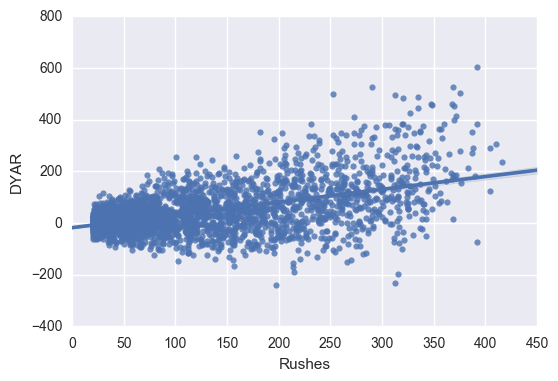

In [9]:
#DYAR compared to rushes
sns.regplot(rb_stats_rush['Rushes'],rb_stats_rush['DYAR'], scatter= True, fit_reg=True, ci = 90)
plt.show()

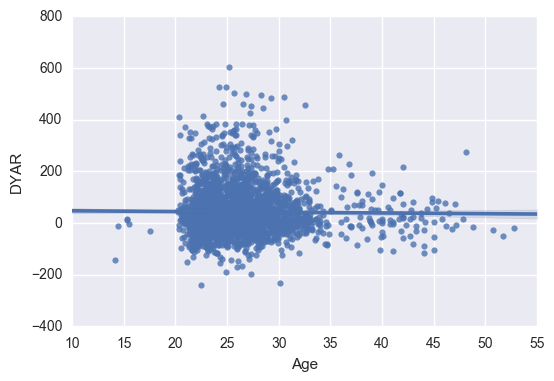

In [10]:
#Regression of age and DYAR
plt.figure(1)
sns.regplot(rb_stats_rush['Age'],rb_stats_rush['DYAR'], scatter= True, fit_reg=True, ci = 90)
plt.show()

In [19]:
#rb DYAR over time
rb_career_data = rb_stats_rush[~pd.isnull(rb_stats_rush['DYAR_t+1'])]
rb_age_means = rb_career_data.groupby(pd.cut(rb_career_data['Age'],np.arange(20,35,1))).mean()

#qb DYAR over time
qb_career_data = qb_stats[~pd.isnull(qb_stats['DYAR_t+1'])]
qb_age_means = qb_career_data.groupby(pd.cut(qb_career_data['Age'],np.arange(20,41,1))).mean()

#wr DYAR over time
wr_career_data = wr_stats[~pd.isnull(wr_stats['DYAR_t+1'])]
wr_age_means = wr_career_data.groupby(pd.cut(wr_career_data['Age'],np.arange(20,35,1))).mean()

#te DYAR over time
te_career_data = te_stats[~pd.isnull(te_stats['DYAR_t+1'])]
te_age_means = te_career_data.groupby(pd.cut(te_career_data['Age'],np.arange(20,35,1))).mean()

rb_age_means

,Unnamed: 0,DYAR,Rushes,Yards,EfYds,TD,Yds,Age,DYAR_t+1,Rushes_t+1,...,DYAR_t-3,ADYAR_t-1,ADYAR_t-2,ADYAR_t-3,Yds_t-1,Yds_t-2,Yds_t-3,AYds_t-1,AYds_t-2,AYds_t-3
Age,,,,,,,,,,,,,,,,,,,,,
"(20, 21]",1644.744186,79.325581,162.790698,NaN,716.441860,5.627907,708.279070,20.674036,59.372093,181.325581,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(21, 22]",1591.731034,36.413793,134.262069,NaN,545.186207,3.468966,548.400000,21.648162,52.268966,135.075862,...,NaN,55.539864,NaN,NaN,692.027027,NaN,NaN,654.470905,NaN,NaN
"(22, 23]",1463.843866,42.059480,121.408922,NaN,506.044610,3.583643,505.531599,22.558456,48.141264,130.152416,...,NaN,50.303436,53.247124,NaN,597.392857,681.093750,NaN,586.015564,632.338958,NaN
"(23, 24]",1457.146417,53.426791,129.476636,NaN,554.838006,3.722741,546.962617,23.511996,41.647975,129.102804,...,93.928571,46.872512,54.093942,55.332538,555.915094,635.677778,703.535714,543.056952,621.655859,651.554810
"(24, 25]",1462.851590,49.021201,137.183746,NaN,573.950530,3.681979,563.325088,24.519338,52.901060,135.586572,...,48.527778,50.635357,50.050685,55.545158,609.207792,596.246914,647.125000,585.223861,576.056406,635.426255
"(25, 26]",1472.424603,63.253968,147.420635,NaN,636.484127,4.246032,616.535714,25.502751,40.797619,136.543651,...,62.574627,52.067060,53.580935,50.702353,617.495575,656.486339,607.910448,607.438585,620.592124,585.851405
"(26, 27]",1491.797170,55.518868,151.108491,NaN,636.745283,4.264151,618.155660,26.477539,54.179245,139.471698,...,85.828358,57.414479,57.936725,57.646233,676.311224,691.650602,710.634328,659.139991,671.622567,666.904764
"(27, 28]",1540.172414,71.264368,156.143678,NaN,680.770115,4.643678,654.534483,27.478633,42.948276,132.017241,...,84.023622,58.077016,60.462565,60.562385,681.881657,719.435897,738.047244,677.006270,691.975181,706.425607
"(28, 29]",1514.488189,52.582677,147.889764,NaN,620.913386,4.055118,602.204724,28.479819,52.433071,118.125984,...,82.732143,58.802951,59.733186,62.038877,710.071429,701.148760,737.616071,685.051282,692.151406,702.076689


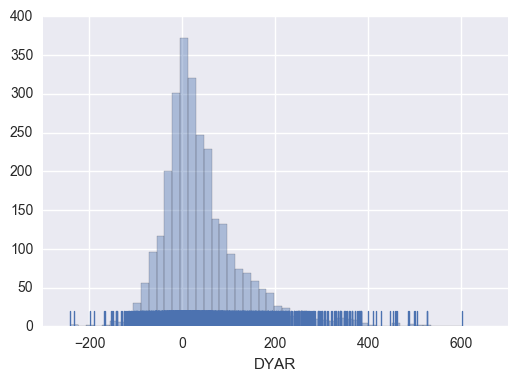

In [20]:
# distritbution of DYAR
plt.figure(1)
x = rb_stats_rush['DYAR']
sns.distplot(x, kde=False, rug=True);
plt.show()

## Aging Curves

In [41]:
#Constructing aging curve with Delta Model

def delta_model(position):
    '''Delta Model: Take difference of DYAR between players who played consecutive years,
    then divide by midpoint of Rushes, Passes, etc. to get difference between years. Exclude all players' 
    last year to avoid  survivorship bias
    Takes in position group as parameter, returns Series with aging curve penalty for year t to t+1'''
    
    if position == "RB_rush":
        df = rb_stats_rush
        df = df[pd.isnull(df['DYAR_t+1'])]
        df['DYAR_diff'] = (df['DYAR_t+1'] - df['DYAR']) / ((df['Rushes'] + df['Rushes_t+1'])/2)
    elif position == "RB_rec":
        df = rb_stats_rec
        df = df[pd.isnull(df['DYAR_t+1'])]
        df['DYAR_diff'] = (df['DYAR_t+1'] - df['DYAR']) / ((df['Targets'] + df['Targets_t+1'])/2)
    elif position == "QB":
        df = qb_stats
        df = df[pd.isnull(df['DYAR_t+1'])]
        df['DYAR_diff'] = (df['DYAR_t+1'] - df['DYAR']) / ((df['Passes'] + df['Passes_t+1'])/2)
    elif position == "WR":
        df = wr_stats
        df = df[pd.isnull(df['DYAR_t+1'])]
        df['DYAR_diff'] = (df['DYAR_t+1'] - df['DYAR']) / ((df['Targets'] + df['Targets_t+1'])/2)
    elif position == "TE":
        df = te_stats
        df = df[pd.isnull(df['DYAR_t+1'])]
        df['DYAR_diff'] = (df['DYAR_t+1'] - df['DYAR']) / ((df['Targets'] + df['Targets_t+1'])/2)    
    
    if position == 'QB':
        aging_penalties = df.groupby(pd.cut(df['Age'],np.arange(20,41,1))).mean()['DYAR_diff']
    else:
        aging_penalties = df.groupby(pd.cut(df['Age'],np.arange(20,35,1))).mean()['DYAR_diff']    
    
    return aging_penalties

In [22]:
# Graph of RB,QB,WR,TE Aging curve from year t to year t+1
rb_age_rush = delta_model("RB_rush")
rb_age_rec = delta_model("RB_rec")
qb_age = delta_model("QB")
wr_age = delta_model("WR")
te_age = delta_model("TE")

lst = []
for age in rb_age_rush.index.values:
    lst.append(float(age[5:7]))
rb_pens_rush = pd.DataFrame({"Age":lst,"Penalty":rb_age_rush.values})

lst = []
for age in rb_age_rec.index.values:
    lst.append(float(age[5:7]))
rb_pens_rec = pd.DataFrame({"Age":lst,"Penalty":rb_age_rec.values})

lst = []
for age in qb_age.index.values:
    lst.append(float(age[5:7]))
qb_pens = pd.DataFrame({"Age":lst,"Penalty":qb_age.values})

lst = []
for age in wr_age.index.values:
    lst.append(float(age[5:7]))
wr_pens = pd.DataFrame({"Age":lst,"Penalty":wr_age.values})

lst = []
for age in te_age.index.values:
    lst.append(float(age[5:7]))
te_pens = pd.DataFrame({"Age":lst,"Penalty":te_age.values})

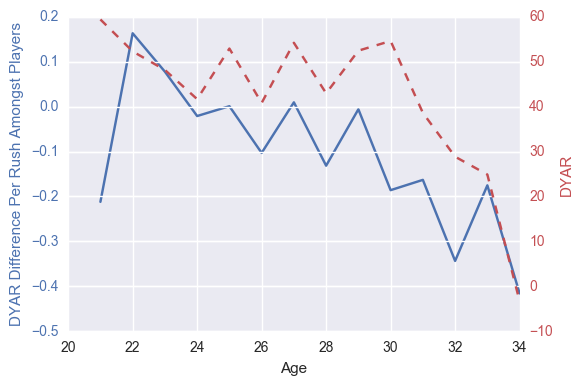

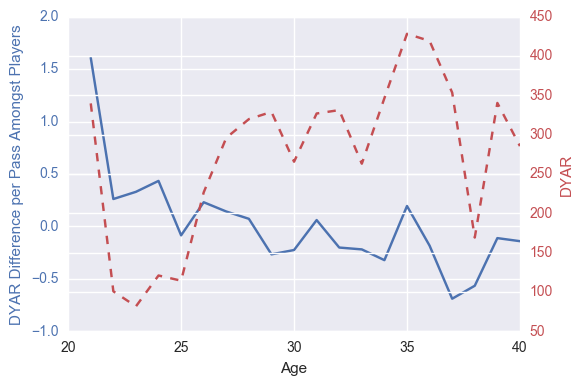

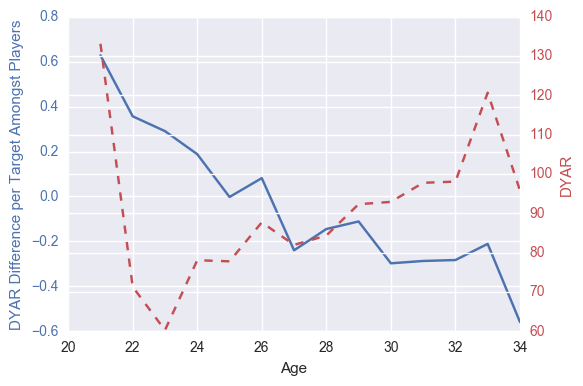

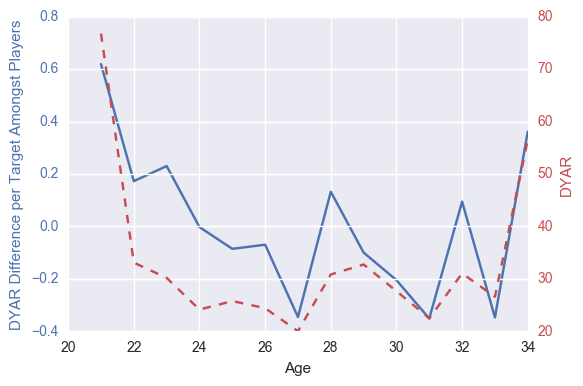

In [23]:
#RB DYAR diff and DYAR by age
plt.figure(1)
fig, ax1 = plt.subplots()
ax1.plot(rb_pens_rush['Age'], rb_pens_rush['Penalty'], 'b-')
ax1.set_xlabel('Age')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('DYAR Difference Per Rush Amongst Players', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(rb_pens_rush['Age'], rb_age_means['DYAR_t+1'].values, 'r--')
ax2.set_ylabel('DYAR', color='r')
ax2.tick_params('y', colors='r')

fig.tight_layout()

#QB DYAR diff and DYAR by age
plt.figure(1)
fig, ax1 = plt.subplots()
ax1.plot(qb_pens['Age'], qb_pens['Penalty'], 'b-')
ax1.set_xlabel('Age')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('DYAR Difference per Pass Amongst Players', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(qb_pens['Age'], qb_age_means['DYAR_t+1'].values, 'r--')
ax2.set_ylabel('DYAR', color='r')
ax2.tick_params('y', colors='r')

fig.tight_layout()
#WR DYAR diff and DYAR by age
plt.figure(1)
fig, ax1 = plt.subplots()
ax1.plot(wr_pens['Age'], wr_pens['Penalty'], 'b-')
ax1.set_xlabel('Age')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('DYAR Difference per Target Amongst Players', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(wr_pens['Age'], wr_age_means['DYAR_t+1'].values, 'r--')
ax2.set_ylabel('DYAR', color='r')
ax2.tick_params('y', colors='r')

fig.tight_layout()
#TE DYAR diff and DYAR by age
plt.figure(1)
fig, ax1 = plt.subplots()
ax1.plot(te_pens['Age'], te_pens['Penalty'], 'b-')
ax1.set_xlabel('Age')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('DYAR Difference per Target Amongst Players', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(te_pens['Age'], te_age_means['DYAR_t+1'].values, 'r--')
ax2.set_ylabel('DYAR', color='r')
ax2.tick_params('y', colors='r')

fig.tight_layout()
plt.show()

Graphs Above: On the left Y-Axis is the change in DYAR per Rush/Pass/Target from the year before. On the right is the average DYAR in that year

## Marcel Model

## Regression Analysis For Season Weights

In [24]:
# Creating Regression Model(s) to get season weights
# Model 1 predicts DYAR in year t based off of DYAR in years t-1,t-2,t-3
# Model 2 predicts DYAR in year t based off of DYAR in years t-1,t-2

import statsmodels.api as sm


def get_weights_touches(position):
    touches = ''
    threshold = 0
    if position == "rb_rush":
        df = rb_stats_rush
        touches = "Rushes"
        threshold = 50
    elif position == "rb_rec":
        df = rb_stats_rec
        touches = "Targets"
        threshold = 50    
    elif position == "qb":
        df = qb_stats
        touches = "Passes"
        threshold = 100
    elif position == "wr":
        df = wr_stats
        touches = "Targets"
        threshold = 50
    elif position == "te":
        df = te_stats
        touches = "Targets"
        threshold = 50
        
    #Get weights for touches
    stats_mod = df[(~pd.isnull(df['{}_t-1'.format(touches)])) & (~pd.isnull(df['{}_t-2'.format(touches)])) & (~pd.isnull(df['{}_t-3'.format(touches)])) & (df[touches] > threshold)]
    stats_mod_2 = df[(~pd.isnull(df['{}_t-1'.format(touches)])) & (~pd.isnull(df['{}_t-2'.format(touches)])) & (df[touches] > threshold)]
    X  = stats_mod[['{}_t-1'.format(touches), '{}_t-2'.format(touches), '{}_t-3'.format(touches)]]
    X_2 = stats_mod_2[['{}_t-1'.format(touches), '{}_t-2'.format(touches)]]
    y = stats_mod[touches]
    y_2 = stats_mod_2[touches]

    model_1 = sm.OLS(y,X).fit()
    model_2 = sm.OLS(y_2,X_2).fit()
    
    touches3 = list(model_1.params)
    touches2 = list(model_2.params)
    
    return touches3,touches2

def get_regression_weights(position,stat):
    touches = ''
    threshold = 0
    if position == "rb_rush":
        df = rb_stats_rush
        touches = "Rushes"
        threshold = 50
    elif position == "rb_rec":
        df = rb_stats_rec
        touches = "Targets"
        threshold = 50    
    elif position == "qb":
        df = qb_stats
        touches = "Passes"
        threshold = 100
    elif position == "wr":
        df = wr_stats
        touches = "Targets"
        threshold = 50
    elif position == "te":
        df = te_stats
        touches = "Targets"
        threshold = 50
        
    stats_mod = df[(~pd.isnull(df['{}_t-1'.format(stat)])) & (~pd.isnull(df['{}_t-2'.format(stat)])) & (~pd.isnull(df['{}_t-3'.format(stat)])) & (df[touches] > threshold)]
    stats_mod_2 = df[(~pd.isnull(df['{}_t-1'.format(stat)])) & (~pd.isnull(df['{}_t-2'.format(stat)])) & (df[touches] > threshold)]
    X  = stats_mod[['{}_t-1'.format(stat), '{}_t-2'.format(stat), '{}_t-3'.format(stat)]]
    X_2 = stats_mod_2[['{}_t-1'.format(stat), '{}_t-2'.format(stat)]]
    y = stats_mod[stat]
    y_2 = stats_mod_2[stat]

    model_1 = sm.OLS(y,X).fit()
    model_2 = sm.OLS(y_2,X_2).fit()
    
    stat3 = list(model_1.params)
    stat2 = list(model_2.params)
    
    return stat3,stat2

## One Year Projections

In [25]:
#One Year projections are simply regressed to the mean and multiplied by aging penalty
def get_one_year_projections(position,stat, current = False):
    touches = ''
    if position == "rb_rush":
        df = rb_stats_rush
        touches = "Rushes"
        age_pens = rb_pens_rush
    elif position == "rb_rec":
        df = rb_stats_rec
        touches = "Targets"
        age_pens = rb_pens_rec    
    elif position == "qb":
        df = qb_stats
        touches = "Passes"
        age_pens = qb_pens
    elif position == "wr":
        df = wr_stats
        touches = "Targets"
        age_pens = wr_pens
    elif position == "te":
        df = te_stats
        touches = "Targets"
        age_pens = te_pens

    #Get Running Backs with 2 years of data available
    if current:
        df['Weighted_{}'.format(stat)] = df['{}'.format(stat)]
        df['Weighted_{}'.format(touches)] = df['{}'.format(touches)]
        df_1 = df[(~pd.isnull(df['Weighted_{}'.format(stat)])) & (~pd.isnull(df['Weighted_{}'.format(touches)])) & (df['Year'] == pd.Timestamp('2017-01-01'))]
         ## Get estimate for stat at league average rate
        df_1['AW{}'.format(stat)] = df['A{}'.format(stat)]
        df_1['AW{}'.format(touches)] = df['{}'.format(touches)]
    else:
        df['Weighted_{}'.format(stat)] = df['{}_t-1'.format(stat)]
        df['Weighted_{}'.format(touches)] = df['{}_t-1'.format(touches)]
        df_1 = df[(~pd.isnull(df['Weighted_{}'.format(stat)])) & (~pd.isnull(df['Weighted_{}'.format(touches)]))]
         ## Get estimate for stat at league average rate
        df_1['AW{}'.format(stat)] = df['A{}_t-1'.format(stat)]
        df_1['AW{}'.format(touches)] = df['{}_t-1'.format(touches)]

   
    ## Regress Weighted stat to Expected stat
    ## how much weighted stats should be regressed to mean
    regression_pct = 1 - df_1['Weighted_{}'.format(stat)].corr(df_1[stat])
    avg_touches  = df_1[touches].mean()
    regression_touches = (regression_pct) * avg_touches
    df_1['Reg_{}'.format(stat)] = df_1['AW{}'.format(stat)] * regression_touches / df_1['AW{}'.format(touches)]
    #Compute Expected yards
    df_1['E{}/Touch'.format(stat)] = (df_1['Reg_{}'.format(stat)] + df['Weighted_{}'.format(stat)]) / (regression_touches + df_1['AW{}'.format(touches)])
    df_1['E{}'.format(stat)] = df_1['E{}/Touch'.format(stat)]  * df_1['Weighted_{}'.format(touches)] 

    # Adding aging curve
    df_1["Age"] = np.ceil(df_1['Age'])
    df_1 = df_1.merge(age_pens, on = 'Age')
    df_1['E{}'.format(stat)] = df_1['E{}'.format(stat)] * (1 + df_1['Penalty'])
    
    return df_1

## Two Year Projections

In [26]:
def get_two_year_projections(position,stat,stat_coef,touches_coef, current = False):
    touches = ''
    if position == "rb_rush":
        df = rb_stats_rush
        touches = "Rushes"
        age_pens = rb_pens_rush
    elif position == "rb_rec":
        df = rb_stats_rec
        touches = "Targets"
        age_pens = rb_pens_rec    
    elif position == "qb":
        df = qb_stats
        touches = "Passes"
        age_pens = qb_pens
    elif position == "wr":
        df = wr_stats
        touches = "Targets"
        age_pens = wr_pens
    elif position == "te":
        df = te_stats
        touches = "Targets"
        age_pens = te_pens


    
    #Get Running Backs with 2 years of data available
    if current:
         ## Get weighted totals
        df['Weighted_{}_2'.format(stat)] = (df['{}'.format(stat)] * stat_coef[0] +  df['{}_t-1'.format(stat)] * stat_coef[1])
        df['Weighted_{}_2'.format(touches)] = df['{}'.format(touches)] * touches_coef[0] +  df['{}_t-1'.format(touches)] * touches_coef[1]
        df_2 = df[(~pd.isnull(df['Weighted_{}_2'.format(stat)])) & (~pd.isnull(df['Weighted_{}_2'.format(touches)])) & (df['Year'] == pd.Timestamp('2017-01-01'))]
        ## Get estimate for stat at league average rate
        df_2['AW{}'.format(stat)] = df['A{}'.format(stat)] * stat_coef[0] +  df['A{}_t-1'.format(stat)] * stat_coef[1]
        df_2['AW{}'.format(touches)] = df['{}'.format(touches)] * stat_coef[0] +  df['{}_t-1'.format(touches)] * stat_coef[1]
    else:
        ## Get weighted totals
        df['Weighted_{}_2'.format(stat)] = (df['{}_t-1'.format(stat)] * stat_coef[0] +  df['{}_t-2'.format(stat)] * stat_coef[1])
        df['Weighted_{}_2'.format(touches)] = df['{}_t-1'.format(touches)] * touches_coef[0] +  df['{}_t-2'.format(touches)] * touches_coef[1]
        df_2 = df[(~pd.isnull(df['Weighted_{}_2'.format(stat)])) & (~pd.isnull(df['Weighted_{}_2'.format(touches)]))]
        ## Get estimate for stat at league average rate
        df_2['AW{}'.format(stat)] = df['A{}_t-1'.format(stat)] * stat_coef[0] +  df['A{}_t-2'.format(stat)] * stat_coef[1]
        df_2['AW{}'.format(touches)] = df['{}_t-1'.format(touches)] * stat_coef[0] +  df['{}_t-2'.format(touches)] * stat_coef[1]

    ## Regress Weighted stat to Expected stat
    
    ## how much weighted stats should be regressed to mean
    regression_pct = 1 - df_2['Weighted_{}_2'.format(stat)].corr(df_2[stat])
    avg_touches  = df_2[touches].mean()
    regression_touches = (regression_pct) * avg_touches
    df_2['Reg_{}'.format(stat)] = df_2['AW{}'.format(stat)] * regression_touches / df_2['AW{}'.format(touches)]

    #Compute Expected yards
    df_2['E{}/Touch'.format(stat)] = (df_2['Reg_{}'.format(stat)] + df['Weighted_{}_2'.format(stat)]) / (regression_touches + df_2['AW{}'.format(touches)])
    df_2['E{}'.format(stat)] = df_2['E{}/Touch'.format(stat)]  * df_2['Weighted_{}_2'.format(touches)] 

    # Adding aging curve
    df_2["Age"] = np.ceil(df_2['Age'])
    df_2 = df_2.merge(age_pens, on = 'Age')
    df_2['E{}'.format(stat)] = df_2['E{}'.format(stat)] * (1 + df_2['Penalty'])
    
    return df_2

## Three Year Projections

In [27]:
def get_three_year_projections(position,stat,stat_coef,touches_coef, current = False):
    touches = ''
    if position == "rb_rush":
        df = rb_stats_rush
        touches = "Rushes"
        age_pens = rb_pens_rush
    elif position == "rb_rec":
        df = rb_stats_rec
        touches = "Targets"
        age_pens = rb_pens_rec    
    elif position == "qb":
        df = qb_stats
        touches = "Passes"
        age_pens = qb_pens
    elif position == "wr":
        df = wr_stats
        touches = "Targets"
        age_pens = wr_pens
    elif position == "te":
        df = te_stats
        touches = "Targets"
        age_pens = te_pens

    
    #Get Running Backs with 2 years of data available
    if current:
        ## Get weighted totals
        df['Weighted_{}_3'.format(stat)] = df['{}'.format(stat)] * stat_coef[0] +  df['{}_t-1'.format(stat)] * stat_coef[1] +  df['{}_t-2'.format(stat)] * stat_coef[2]
        df['Weighted_{}_3'.format(touches)] = df['{}'.format(touches)] * touches_coef[0] +  df['{}_t-1'.format(touches)] * touches_coef[1] +  df['{}_t-2'.format(touches)] * touches_coef[2]
        df_3 = df[(~pd.isnull(df['Weighted_{}_3'.format(stat)])) & (~pd.isnull(df['Weighted_{}_3'.format(touches)])) & (df['Year'] == pd.Timestamp('2017-01-01'))]
        ## Get estimate for stat at league average rate
        df_3['AW{}'.format(stat)] = df['A{}'.format(stat)] * stat_coef[0] +  df['A{}_t-1'.format(stat)] * stat_coef[1] +  df['A{}_t-2'.format(stat)] * stat_coef[2]
        df_3['AW{}'.format(touches)] = df['{}'.format(touches)] * stat_coef[0] +  df['{}_t-1'.format(touches)] * stat_coef[1] +  df['{}_t-2'.format(touches)] * stat_coef[2]
    else:
        ## Get weighted totals
        df['Weighted_{}_3'.format(stat)] = df['{}_t-1'.format(stat)] * stat_coef[0] +  df['{}_t-2'.format(stat)] * stat_coef[1] +  df['{}_t-3'.format(stat)] * stat_coef[2]
        df['Weighted_{}_3'.format(touches)] = df['{}_t-1'.format(touches)] * touches_coef[0] +  df['{}_t-2'.format(touches)] * touches_coef[1] +  df['{}_t-3'.format(touches)] * touches_coef[2]
        df_3 = df[(~pd.isnull(df['Weighted_{}_3'.format(stat)])) & (~pd.isnull(df['Weighted_{}_3'.format(touches)]))]
        ## Get estimate for stat at league average rate
        df_3['AW{}'.format(stat)] = df['A{}_t-1'.format(stat)] * stat_coef[0] +  df['A{}_t-2'.format(stat)] * stat_coef[1] +  df['A{}_t-3'.format(stat)] * stat_coef[2]
        df_3['AW{}'.format(touches)] = df['{}_t-1'.format(touches)] * stat_coef[0] +  df['{}_t-2'.format(touches)] * stat_coef[1] +  df['{}_t-3'.format(touches)] * stat_coef[2]

    
    ## Regress Weighted stat to Expected stat
    ## how much weighted stats should be regressed to mean
    regression_pct = 1 - df_3['Weighted_{}_3'.format(stat)].corr(df_3[stat])
    avg_touches  = df_3[touches].mean()
    regression_touches = (regression_pct) * avg_touches
    df_3['Reg_{}'.format(stat)] = df_3['AW{}'.format(stat)] * regression_touches / df_3['AW{}'.format(touches)]

    #Compute Expected yards
    df_3['E{}/Touch'.format(stat)] = (df_3['Reg_{}'.format(stat)] + df['Weighted_{}_3'.format(stat)]) / (regression_touches + df_3['AW{}'.format(touches)])
    df_3['E{}'.format(stat)] = df_3['E{}/Touch'.format(stat)]  * df_3['Weighted_{}_3'.format(touches)] 

    # Adding aging curve
    df_3["Age"] = np.ceil(df_3['Age'])
    df_3 = df_3.merge(age_pens, on = 'Age')
    df_3['E{}'.format(stat)] = df_3['E{}'.format(stat)] * (1 + df_3['Penalty'])
    
    return df_3

## Results - Comparing Last Year's DYAR correlation vs. Models

In [28]:
rb_rushes_coefs3,rb_rushes_coefs2 = get_weights_touches('rb_rush')
rb_targets_coefs3,rb_targets_coefs2 = get_weights_touches('rb_rec')
rb_dyar_coefs3,rb_dyar_coefs2 = get_regression_weights('rb_rush','DYAR')
rb_rdyar_coefs3,rb_rdyar_coefs2 = get_regression_weights('rb_rec','DYAR')
rb_Yds_coefs3,rb_Yds_coefs2 = get_regression_weights('rb_rush','Yds')
rb_rYds_coefs3,rb_rYds_coefs2 = get_regression_weights('rb_rec','Yds')


qb_passes_coefs3,qb_passes_coefs2 = get_weights_touches('qb')
qb_dyar_coefs3,qb_dyar_coefs2 = get_regression_weights('qb','DYAR')
qb_Yds_coefs3,qb_Yds_coefs2 = get_regression_weights('qb','Yds')


wr_targets_coefs3,wr_targets_coefs2 = get_weights_touches('wr')
wr_dyar_coefs3,wr_dyar_coefs2 = get_regression_weights('wr','DYAR')
wr_Yds_coefs3,wr_Yds_coefs2 = get_regression_weights('wr','Yds')


te_targets_coefs3,te_targets_coefs2 = get_weights_touches('te')
te_dyar_coefs3,te_dyar_coefs2 = get_regression_weights('te','DYAR')
te_Yds_coefs3,te_Yds_coefs2 = get_regression_weights('te','Yds')


rb_stats_rush_1 = get_one_year_projections('rb_rush','DYAR')
rb_stats_rec_1 = get_one_year_projections('rb_rec','DYAR')
qb_stats_1 = get_one_year_projections('qb','DYAR')
wr_stats_1 = get_one_year_projections('wr','DYAR')
te_stats_1 = get_one_year_projections('te','DYAR')

rb_stats_rush_2 = get_two_year_projections('rb_rush','DYAR',rb_dyar_coefs2,rb_rushes_coefs2)
rb_stats_rec_2 = get_two_year_projections('rb_rec','DYAR',rb_rdyar_coefs2,rb_targets_coefs2)
qb_stats_2 = get_two_year_projections('qb','DYAR',qb_dyar_coefs2,qb_passes_coefs2)
wr_stats_2 = get_two_year_projections('wr','DYAR',qb_dyar_coefs2,wr_targets_coefs2)
te_stats_2 = get_two_year_projections('te','DYAR',qb_dyar_coefs2,te_targets_coefs2)

rb_stats_rush_3 = get_three_year_projections('rb_rush','DYAR',rb_dyar_coefs3,rb_rushes_coefs3)
rb_stats_rec_3 = get_three_year_projections('rb_rec','DYAR',rb_rdyar_coefs3,rb_targets_coefs3)
qb_stats_3 = get_three_year_projections('qb','DYAR',qb_dyar_coefs3,qb_passes_coefs3)
wr_stats_3 = get_three_year_projections('wr','DYAR',wr_dyar_coefs3,wr_targets_coefs3)
te_stats_3 = get_three_year_projections('te','DYAR',te_dyar_coefs3,te_targets_coefs3)

In [29]:
print( "QB Projections (DYAR): ")
print("COMPARING TO LAST YEAR\n",qb_stats[['DYAR','DYAR_t-1']].corr()['DYAR'][1])
print("ONE YEAR\n",qb_stats_1[['DYAR','EDYAR']].corr()['EDYAR'][0])
print("TWO YEARS\n",qb_stats_2[['DYAR','EDYAR']].corr()['EDYAR'][0])
print("THREE YEARS\n",qb_stats_3[['DYAR','EDYAR']].corr()['EDYAR'][0])
print()

print( "RB Projections Rushing(DYAR): ")
print("COMPARING TO LAST YEAR\n",rb_stats_rush[['DYAR','DYAR_t-1']].corr()['DYAR'][1])
print("ONE YEAR\n",rb_stats_rush_1[['DYAR','EDYAR']].corr()['EDYAR'][0])
print("TWO YEARS\n",rb_stats_rush_2[['DYAR','EDYAR']].corr()['EDYAR'][0])
print("THREE YEARS\n",rb_stats_rush_3[['DYAR','EDYAR']].corr()['EDYAR'][0])
print()

print( "RB Projections Receiving(DYAR): ")
print("COMPARING TO LAST YEAR\n",rb_stats_rec[['DYAR','DYAR_t-1']].corr()['DYAR'][1])
print("ONE YEAR\n",rb_stats_rec_1[['DYAR','EDYAR']].corr()['EDYAR'][0])
print("TWO YEARS\n",rb_stats_rec_2[['DYAR','EDYAR']].corr()['EDYAR'][0])
print("THREE YEARS\n",rb_stats_rec_3[['DYAR','EDYAR']].corr()['EDYAR'][0])
print()

print( "WR Projections (DYAR): ")
print("COMPARING TO LAST YEAR\n",wr_stats[['DYAR','DYAR_t-1']].corr()['DYAR'][1])
print("ONE YEAR\n",wr_stats_1[['DYAR','EDYAR']].corr()['EDYAR'][0])
print("TWO YEARS\n",wr_stats_2[['DYAR','EDYAR']].corr()['EDYAR'][0])
print("THREE YEARS\n",wr_stats_3[['DYAR','EDYAR']].corr()['EDYAR'][0])
print()

print( "TE Projections (DYAR): ")
print("COMPARING TO LAST YEAR\n",te_stats[['DYAR','DYAR_t-1']].corr()['DYAR'][1])
print("ONE YEAR\n",te_stats_1[['DYAR','EDYAR']].corr()['EDYAR'][0])
print("TWO YEARS\n",te_stats_2[['DYAR','EDYAR']].corr()['EDYAR'][0])
print("THREE YEARS\n",te_stats_3[['DYAR','EDYAR']].corr()['EDYAR'][0])
print()

QB Projections (DYAR): 
COMPARING TO LAST YEAR
 0.542816101024
ONE YEAR
 0.523508480369
TWO YEARS
 0.578560648917
THREE YEARS
 0.570625683188

RB Projections Rushing(DYAR): 
COMPARING TO LAST YEAR
 0.331691089619
ONE YEAR
 0.341681185072
TWO YEARS
 0.354697038851
THREE YEARS
 0.365050191687

RB Projections Receiving(DYAR): 
COMPARING TO LAST YEAR
 0.339126391915
ONE YEAR
 0.344583492031
TWO YEARS
 0.403992932813
THREE YEARS
 0.428121677821

WR Projections (DYAR): 
COMPARING TO LAST YEAR
 0.376985056593
ONE YEAR
 0.374448074923
TWO YEARS
 0.40993196356
THREE YEARS
 0.417307604724

TE Projections (DYAR): 
COMPARING TO LAST YEAR
 0.402914390539
ONE YEAR
 0.419728451218
TWO YEARS
 0.472939038559
THREE YEARS
 0.515218371701



In [30]:
rb_stats_rush_e = get_one_year_projections('rb_rush','Yds')
qb_stats_e = get_one_year_projections('qb','Yds')
wr_stats_e = get_one_year_projections('wr','Yds')
te_stats_e = get_one_year_projections('te','Yds')


rb_stats_rush_2e = get_two_year_projections('rb_rush','Yds',rb_Yds_coefs2,rb_rushes_coefs2)
qb_stats_2e = get_two_year_projections('qb','Yds',qb_Yds_coefs2,qb_passes_coefs2)
wr_stats_2e = get_two_year_projections('wr','Yds',qb_Yds_coefs2,wr_targets_coefs2)
te_stats_2e = get_two_year_projections('te','Yds',qb_Yds_coefs2,te_targets_coefs2)

rb_stats_rush_3e = get_three_year_projections('rb_rush','Yds',rb_Yds_coefs3,rb_rushes_coefs3)
qb_stats_3e = get_three_year_projections('qb','Yds',qb_Yds_coefs3,qb_passes_coefs3)
wr_stats_3e = get_three_year_projections('wr','Yds',wr_Yds_coefs3,wr_targets_coefs3)
te_stats_3e = get_three_year_projections('te','Yds',te_Yds_coefs3,te_targets_coefs3)

In [31]:
print( "QB Projections (Yds): ")
print("COMPARING TO LAST YEAR\n",qb_stats[['Yds','Yds_t-1']].corr()['Yds'][1])
print("ONE YEAR\n",qb_stats_e[['Yds','EYds']].corr()['EYds'][0])
print("TWO YEARS\n",qb_stats_2e[['Yds','EYds']].corr()['EYds'][0])
print("THREE YEARS\n",qb_stats_3e[['Yds','EYds']].corr()['EYds'][0])
print()

print( "RB Projections (Yds): ")
print("COMPARING TO LAST YEAR\n",rb_stats_rush[['Yds','Yds_t-1']].corr()['Yds'][1])
print("ONE YEAR\n",rb_stats_rush_e[['Yds','EYds']].corr()['EYds'][0])
print("TWO YEARS\n",rb_stats_rush_2e[['Yds','EYds']].corr()['EYds'][0])
print("THREE YEARS\n",rb_stats_rush_3e[['Yds','EYds']].corr()['EYds'][0])
print()

print( "WR Projections (Yds): ")
print("COMPARING TO LAST YEAR\n",wr_stats[['Yds','Yds_t-1']].corr()['Yds'][1])
print("ONE YEAR\n",wr_stats_e[['Yds','EYds']].corr()['EYds'][0])
print("TWO YEARS\n",wr_stats_2e[['Yds','EYds']].corr()['EYds'][0])
print("THREE YEARS\n",wr_stats_3e[['Yds','EYds']].corr()['EYds'][0])
print()

print( "TE Projections (Yds): ")
print("COMPARING TO LAST YEAR\n",te_stats[['Yds','Yds_t-1']].corr()['Yds'][1])
print("ONE YEAR\n",te_stats_e[['Yds','EYds']].corr()['EYds'][0])
print("TWO YEARS\n",te_stats_2e[['Yds','EYds']].corr()['EYds'][0])
print("THREE YEARS\n",te_stats_3e[['Yds','EYds']].corr()['EYds'][0])
print()

QB Projections (Yds): 
COMPARING TO LAST YEAR
 0.636459974462
ONE YEAR
 0.579498827576
TWO YEARS
 0.589288446827
THREE YEARS
 0.576665748747

RB Projections (Yds): 
COMPARING TO LAST YEAR
 0.593430446753
ONE YEAR
 0.601175955437
TWO YEARS
 0.617417830241
THREE YEARS
 0.624368833659

WR Projections (Yds): 
COMPARING TO LAST YEAR
 0.569942467964
ONE YEAR
 0.537588982374
TWO YEARS
 0.536706245233
THREE YEARS
 0.529109021799

TE Projections (Yds): 
COMPARING TO LAST YEAR
 0.649808579936
ONE YEAR
 0.617613046567
TWO YEARS
 0.631885644758
THREE YEARS
 0.637047324554



## Current Year Projections

In [39]:
rb_current_projs = get_two_year_projections('rb_rush','Yds',rb_Yds_coefs2,rb_rushes_coefs2, current = True)

rb_rec_current_projs = get_two_year_projections('rb_rec','Yds',rb_rYds_coefs2,rb_targets_coefs2,current = True)

qb_current_projs = get_two_year_projections('qb','Yds',qb_Yds_coefs2,qb_passes_coefs2,current = True)

wr_current_projs = get_two_year_projections('wr','Yds',wr_Yds_coefs2,wr_targets_coefs2,current = True)

te_current_projs = get_two_year_projections('te','Yds',te_Yds_coefs2,te_targets_coefs2,current = True)

rb_rooks_current_projs = get_one_year_projections('rb_rush','Yds',current = True)
rb_rooks_current_projs = rb_rooks_current_projs[pd.isnull(rb_rooks_current_projs['Yds_t-1'])]

print(rb_rooks_current_projs[['Player','AWRushes','EYds']].sort_values('EYds',ascending = False)[:15])
print(rb_current_projs[['Player','AWRushes','EYds']].sort_values('EYds',ascending = False)[:15])
print(rb_rec_current_projs[['Player','AWTargets','EYds']].sort_values('EYds',ascending = False)[:15])
print(qb_current_projs[['Player','AWPasses','EYds']].sort_values('EYds',ascending = False)[:15])
print(wr_current_projs[['Player','AWTargets','EYds']].sort_values('EYds',ascending = False)[:15])
print(te_current_projs[['Player','AWTargets','EYds']].sort_values('EYds',ascending = False)[:15])

         Player  AWRushes         EYds
16       K.Hunt       272  1543.317317
18  L.Fournette       268  1209.532788
15     A.Kamara       120   846.672952
20     S.Perine       174   696.644365
19     M.Breida       104   547.778791
6     W.Gallman       111   512.915872
8       A.Jones        81   482.744350
61      J.Mixon       177   477.548469
24      T.Cohen        87   432.640574
22       D.Cook        74   411.706353
9     C.Clement        74   345.894947
62  C.McCaffrey       117   342.794693
14    E.McGuire        88   339.429621
21     A.Ekeler        47   302.383197
64       M.Mack        93   287.632328
       Player    AWRushes         EYds
19  E.Elliott  239.455109  1259.961517
10     L.Bell  269.811061  1191.970204
2    J.Howard  239.927993  1167.359106
0    T.Gurley  249.231110  1152.904859
42    L.McCoy  240.812051  1073.941894
55   M.Gordon  245.355671   960.970225
54    J.Ajayi  200.988510   900.105225
20   M.Ingram  198.500838   870.778966
11  D.Freeman  183.605556

In [40]:
qb_pens

,Age,Penalty
0,21.0,1.607920
1,22.0,0.261259
2,23.0,0.329946
3,24.0,0.434048
4,25.0,-0.084932
5,26.0,0.230685
6,27.0,0.142228
7,28.0,0.072669
8,29.0,-0.266021
9,30.0,-0.224716
